# Previsão de Preços de Tomate no Atacado

## Contexto

Este trabalho busca encontrar uma solução que faz a previsão de preços para tomates vendidos por produtores(atacado). Como forma de auxiliar agricultores a tomarem a melhor decisão durante o ciclo de sua lavoura.

Para isso será elaborado um modelo que com base em dados passados, como o próprio preço, conseguirá predizer valores futuros.


## Pergunta de Negócio

Durante o ciclo de uma lavoura o preço do tomate tende a oscilar periodicamente, de modo que para o agricultor é difícil de projetar resultados da sua lavoura de maneira precisa, o que dificulta a gestão de sua lavoura no dia a dia.

Com base nisso o nosso modelo busca entregar uma solução confiável que possa orientar o agricultor tanto na projeção de resultado como também de maneira estratégica para a gestão da lavoura.

## Enquadramento do Problema
Para esse projeto foi utilizado de maneira inicial um modelo de **Aprendizado supervisionado de regressão linear** para efetuar a previsão.
Este modelo foi escolhido inicialmente devido as caracteristicas do problema.

In [24]:
import pandas as pd
import numpy as np
import matplotlib as plt
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D
from sklearn.model_selection import train_test_split

## Base de Dados

A base de dados utilizada nesse projeto, pode ser encontrada no site da [HF Brasil](https://www.hfbrasil.org.br/br/banco-de-dados-precos-medios-dos-hortifruticolas.aspx). HF Brasil é parte do CEPEA - Centro de Estudos Avançados em Economia Aplicada, da ESALQ - Escola Superior de Agricultura "Luiz de Queiroz", reúne pesquisadores e analistas de mercados, dedicados aos aspectos econômicos dos setores de frutas e hortaliças. Possui como missão produzir informações de qualidade pautadas em valores como imparcialidade e ética,que contribuam para o desenvolvimento sustentável dos setores estudados.

### Sobre a base de dados
A base de dados inicialmente utilizada foi um arquivo gerado direto do site da HF Brasil, em formato .xlsx, que trazia de maneira geral informações sobre a venda de tomate no atacado no período de janeiro de 2015 á abril de 2023, nessa base de dados era trazido as informações de Produto, Região, Dia, Mês, Ano, Moeda, Unidade e Preço.

Como mostra o Data Frame abaixo:

In [ ]:
df = pd.read_excel('tomate-precos-medios.xlsx')
df

Porém devido as necessidades do projeto essa base de dados foi alterada e reutilizada como será visto mais a frente.

## Análise Exploratória dos Dados

Inicialmente foi feito uma análise exploratória dos dados buscando verificar a qualidade dos dados. Também foi feito as customizações necessárias tal como a limpeza e verificação das características dos dados. Após isso foi feito o estudo dos dados.

### Qualidade dos Dados

In [ ]:
display(df.info())
display(df.describe())

### Limpeza dos dados e Customização

In [ ]:
# Função utilizada na Limpeza dos Dados:
def escalona_df(df):
    df.astype({'Dia':'int32','Mês':'int32','Ano':'int32'})
    df = df.astype({'Dia':str,'Mês':str,'Ano':str})
    df['Data'] = df[['Dia','Mês','Ano']].agg('-'.join,axis=1)
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    df = df.sort_values(by=["Região","Produto","Unidade","Data"])
    return df
def aumento_e_acelaracao(df):
    regioes = np.array(df['Região'].unique())
    produtos = np.array(df['Produto'].unique())
    unidades = np.array(df['Unidade'].unique())
    df_list = []
    for regiao in regioes:
        for produto in produtos:
            for unidade in unidades:
                df_aux = df.loc[(df["Unidade"] == unidade) & (df['Produto'] == produto) & (df['Região'] == regiao)].reset_index()
                df_aux['Aumento'] = df_aux['Preço'].diff()
                df_aux['Aceleracao'] = df_aux['Aumento'].diff()
                df_list.append(df_aux)
    columns = df.columns
    df_tratado = pd.DataFrame(columns=columns)
    for dataframe in df_list:
        if dataframe.shape[0] > 10:
            df_tratado = pd.concat([df_tratado,dataframe],ignore_index=True)
    return df_tratado

In [ ]:
df.drop_duplicates(inplace = True)
df = escalona_df(df)
df = aumento_e_acelaracao(df)
df.drop(axis=1,columns=['index','Moeda'],inplace=True)
df.info()

### Estudo dos Dados

Verificação das Regiões

In [ ]:
regiao_dist = df['Região'].value_counts()
print(regiao_dist)
fig = px.pie(df, names='Produto')
fig.update_layout(height=400,width=600)
fig.show()

Com o gráfico acima é visto que mais de 50% dos valores estão concentrados nas regiões de Campinas e São Paulo. Dessa forma seguiremos somente com as duas regiões visto que o peso dos preços nesta região serão maiores e mais precisos.

Verificação das Unidades, com relação as Regiões selecionadas

In [ ]:
df_sp = df.loc[df['Região']=="São Paulo (capital)"].sort_values(by=["Produto","Data"])
df_ca = df.loc[df['Região']=="Campinas"].sort_values(by=["Produto","Data"])

In [ ]:
unidade_dist_sp = df_sp['Unidade'].value_counts()
unidade_dist_ca = df_ca['Unidade'].value_counts()
print(unidade_dist_sp)
print(unidade_dist_ca)
fig = px.pie(df_sp, names='Unidade')
fig.update_layout(height=400,width=600)
fig.show()
fig = px.pie(df_ca, names='Unidade')
fig.update_layout(height=400,width=600)
fig.show()

Como visto nas regiões selecionadas há apenas unidades do tipo "Caixa 20Kg"

Verificação quanto aos produtos relacionado com os Anos das amostras

In [ ]:
fig = px.histogram(df_sp, x='Ano',color='Produto',text_auto=True)
fig.update_layout(title = "Distribuição de valores disponíveis por Ano em São Paulo")
fig.show()
fig = px.histogram(df_ca, x='Ano',color='Produto',text_auto=True)
fig.update_layout(title = "Distribuição de valores disponíveis por Ano em Campinas")
fig.show()

Como verificado apenas os Produtos dos Tipos "Italiano - atacado" e "Salada longa Vida AA - atacado" estão presentes nas duas regiões e em todos os anos. Dessa forma será prosseguido somente com essas duas qualidades

### Considerações

Com as informações acima foi buscado novamente os dados na fonte, dessa vez pegando desde o ano de 2000 até o ano de 2023, e separando em duas bases de dados, São Paulo e Campinas, pegando um espaço de tempo maior para as duas regiões. Deixando a base a base de dados mais robusta.

In [57]:
df_campinas = pd.read_excel("tomate-precos-medios-campinas.xlsx")
df_sao_paulo = pd.read_excel("tomate-precos-medios-sao-paulo.xlsx")

In [19]:
print(df_campinas.info())
print("-"*20)
print(df_sao_paulo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11637 entries, 0 to 11636
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Produto  11637 non-null  object 
 1   Região   11637 non-null  object 
 2   Dia      11637 non-null  int64  
 3   Mês      11637 non-null  int64  
 4   Ano      11637 non-null  int64  
 5   Moeda    11637 non-null  object 
 6   Unidade  11637 non-null  object 
 7   Preço    11637 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 727.4+ KB
None
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19563 entries, 0 to 19562
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Produto  19563 non-null  object 
 1   Região   19563 non-null  object 
 2   Dia      19563 non-null  int64  
 3   Mês      19563 non-null  int64  
 4   Ano      19563 non-null  int64  
 5   Moeda    19563 non-null  object 
 6   Unida

In [58]:
# Campinas
df_campinas.drop_duplicates(inplace = True)
df_campinas = escalona_df(df_campinas)
df_campinas = aumento_e_acelaracao(df_campinas)
df_campinas.drop(axis=1,columns=['index','Moeda'],inplace=True)
df_campinas.info()

# São Paulo
df_sao_paulo.drop_duplicates(inplace = True)
df_sao_paulo = escalona_df(df_sao_paulo)
df_sao_paulo = aumento_e_acelaracao(df_sao_paulo)
df_sao_paulo.drop(axis=1,columns=['index','Moeda'],inplace=True)
df_sao_paulo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11622 entries, 0 to 11621
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Produto     11622 non-null  object        
 1   Região      11622 non-null  object        
 2   Dia         11622 non-null  object        
 3   Mês         11622 non-null  object        
 4   Ano         11622 non-null  object        
 5   Unidade     11622 non-null  object        
 6   Preço       11622 non-null  float64       
 7   Data        11622 non-null  datetime64[ns]
 8   Aumento     11615 non-null  float64       
 9   Aceleracao  11608 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 908.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Produto     19536 non-null  obje

In [22]:
df_sp_salada_AA = df_sao_paulo.loc[df_sao_paulo['Produto'] == "Salada longa vida AA - atacado"]
display(df_sp_salada_AA.head())
df_sp_italiano = df_sao_paulo.loc[df_sao_paulo['Produto'] == "Italiano - atacado"]
display(df_sp_italiano.head())
df_ca_salada_AA = df_campinas.loc[df_campinas['Produto'] == "Salada longa vida AA - atacado"]
display(df_ca_salada_AA.head())
df_ca_italiano = df_campinas.loc[df_campinas['Produto'] == "Italiano - atacado"]
display(df_ca_italiano.head())

,Produto,Região,Dia,Mês,Ano,Unidade,Preço,Data,Aumento,Aceleracao
8880,Salada longa vida AA - atacado,São Paulo (capital),6,2,2001,Caixa 20 kg,15.00,2001-02-06,NaN,NaN
8881,Salada longa vida AA - atacado,São Paulo (capital),7,2,2001,Caixa 20 kg,16.00,2001-02-07,1.00,NaN
8882,Salada longa vida AA - atacado,São Paulo (capital),8,2,2001,Caixa 20 kg,16.33,2001-02-08,0.33,-0.67
8883,Salada longa vida AA - atacado,São Paulo (capital),9,2,2001,Caixa 20 kg,17.20,2001-02-09,0.87,0.54
8884,Salada longa vida AA - atacado,São Paulo (capital),12,2,2001,Caixa 20 kg,15.50,2001-02-12,-1.70,-2.57


,Produto,Região,Dia,Mês,Ano,Unidade,Preço,Data,Aumento,Aceleracao
0,Italiano - atacado,São Paulo (capital),20,6,2006,Caixa 20 kg,17.67,2006-06-20,NaN,NaN
1,Italiano - atacado,São Paulo (capital),21,6,2006,Caixa 20 kg,17.33,2006-06-21,-0.34,NaN
2,Italiano - atacado,São Paulo (capital),22,6,2006,Caixa 20 kg,15.00,2006-06-22,-2.33,-1.99
3,Italiano - atacado,São Paulo (capital),27,6,2006,Caixa 20 kg,16.50,2006-06-27,1.50,3.83
4,Italiano - atacado,São Paulo (capital),29,6,2006,Caixa 20 kg,16.50,2006-06-29,0.00,-1.50


,Produto,Região,Dia,Mês,Ano,Unidade,Preço,Data,Aumento,Aceleracao
4293,Salada longa vida AA - atacado,Campinas,14,3,2001,Caixa 20 kg,14.67,2001-03-14,NaN,NaN
4294,Salada longa vida AA - atacado,Campinas,15,3,2001,Caixa 20 kg,14.40,2001-03-15,-0.27,NaN
4295,Salada longa vida AA - atacado,Campinas,16,3,2001,Caixa 20 kg,15.75,2001-03-16,1.35,1.62
4296,Salada longa vida AA - atacado,Campinas,19,3,2001,Caixa 20 kg,16.00,2001-03-19,0.25,-1.10
4297,Salada longa vida AA - atacado,Campinas,20,3,2001,Caixa 20 kg,16.75,2001-03-20,0.75,0.50


,Produto,Região,Dia,Mês,Ano,Unidade,Preço,Data,Aumento,Aceleracao
0,Italiano - atacado,Campinas,8,6,2007,Caixa 20 kg,37.5,2007-06-08,NaN,NaN
1,Italiano - atacado,Campinas,1,8,2007,Caixa 20 kg,20.0,2007-08-01,-17.5,NaN
2,Italiano - atacado,Campinas,3,8,2007,Caixa 20 kg,27.0,2007-08-03,7.0,24.5
3,Italiano - atacado,Campinas,17,8,2007,Caixa 20 kg,27.5,2007-08-17,0.5,-6.5
4,Italiano - atacado,Campinas,20,8,2007,Caixa 20 kg,30.0,2007-08-20,2.5,2.0


In [50]:
df_sp_salada_AA['Data'] = pd.to_datetime(df_sp_salada_AA['Data'], format='%Y-%m-%d')
df_ca_salada_AA['Data'] = pd.to_datetime(df_ca_salada_AA['Data'], format='%Y-%m-%d')
df_ca_italiano['Data'] = pd.to_datetime(df_ca_italiano['Data'], format='%Y-%m-%d')
df_sp_italiano['Data'] = pd.to_datetime(df_sp_italiano['Data'], format='%Y-%m-%d')

<ipython-input-50-861752aa9111>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-861752aa9111>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-861752aa9111>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-861752a

In [51]:
df_preco_sp_italiano = df_sp_italiano[['Data','Preço']]
df_preco_sp_italiano = df_preco_sp_italiano.set_index(pd.DatetimeIndex(df_preco_sp_italiano['Data'].values))
df_preco_sp_italiano.drop('Data', axis=1,inplace=True)

df_preco_ca_italiano = df_ca_italiano[['Data','Preço']]
df_preco_ca_italiano = df_preco_ca_italiano.set_index(pd.DatetimeIndex(df_preco_ca_italiano['Data'].values))
df_preco_ca_italiano.drop('Data', axis=1,inplace=True)

df_preco_ca_salada_AA = df_ca_salada_AA[['Data','Preço']]
df_preco_ca_salada_AA = df_preco_ca_salada_AA.set_index(pd.DatetimeIndex(df_preco_ca_salada_AA['Data'].values))
df_preco_ca_salada_AA.drop('Data', axis=1,inplace=True)

df_preco_sp_salada_AA = df_sp_salada_AA[['Data','Preço']]
df_preco_sp_salada_AA = df_preco_sp_salada_AA.set_index(pd.DatetimeIndex(df_preco_sp_salada_AA['Data'].values))
df_preco_sp_salada_AA.drop('Data', axis=1,inplace=True)

In [52]:
sc = StandardScaler()
sc.fit(df_preco_sp_italiano)
dado_escalado_sp_italiano = sc.transform(df_preco_sp_italiano)

sc = StandardScaler()
sc.fit(df_preco_ca_italiano)
dado_escalado_ca_italiano = sc.transform(df_preco_ca_italiano)

sc = StandardScaler()
sc.fit(df_preco_ca_salada_AA)
dado_escalado_ca_salada_AA = sc.transform(df_preco_ca_salada_AA)

sc = StandardScaler()
sc.fit(df_preco_sp_salada_AA)
dado_escalado_sp_salada_AA = sc.transform(df_preco_sp_salada_AA)

<ipython-input-63-5df99a9da5ab>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-5df99a9da5ab>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0, 'Data')

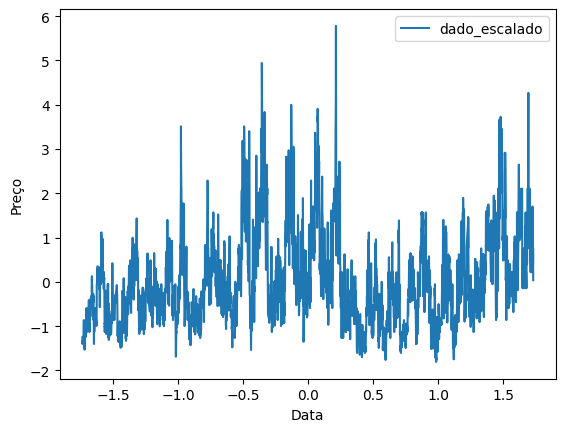

In [63]:
df_sp_italiano = df_sao_paulo.loc[df_sao_paulo['Produto'] == "Italiano - atacado"]
df_sp_italiano['Data'] = pd.to_datetime(df_sp_italiano['Data'])
df_sp_italiano['Data'] = pd.to_numeric(df_sp_italiano['Data'])
df_preco_sp_italiano = df_sp_italiano[['Data','Preço']]
sc = StandardScaler()
sc.fit(df_preco_sp_italiano)
dado_escalado_sp_italiano = sc.transform(df_preco_sp_italiano)
x = dado_escalado_sp_italiano[:,0]
y = dado_escalado_sp_italiano[:,1]
sns.lineplot(x=x,y=y,label='dado_escalado')
plt.ylabel('Preço')
plt.xlabel('Data')

<Axes: >

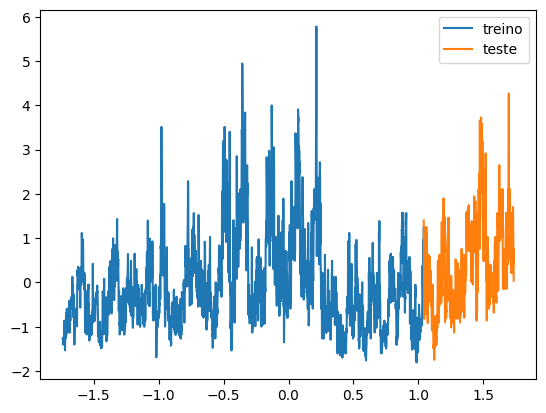

In [64]:
tamanho_treino = int(len(dado_escalado_sp_italiano)*0.8)
tamano_teste = len(dado_escalado_sp_italiano) - tamanho_treino
x_treino = x[0:tamanho_treino]
y_treino = y[0:tamanho_treino]
x_teste = x[tamanho_treino:len(dado_escalado_sp_italiano)]
y_teste = y[tamanho_treino:len(dado_escalado_sp_italiano)]
sns.lineplot(x=x_treino,y=y_treino,label='treino')
sns.lineplot(x=x_teste,y=y_teste,label='teste')

103/103 [==============================] - 0s 1ms/step


<Axes: >

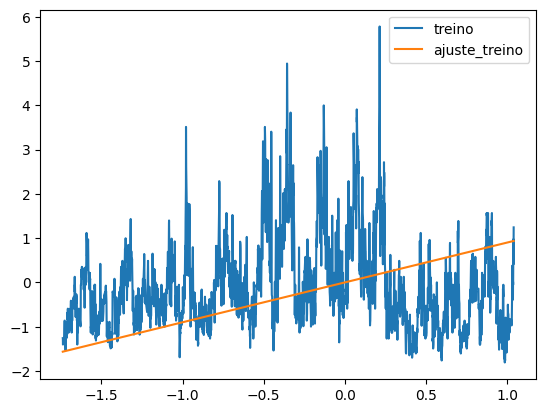

In [65]:
regressor = Sequential()
regressor.add(Dense(1, input_dim=1,kernel_initializer="Ones",
                    activation="linear",use_bias=False))
regressor.compile(loss='mean_squared_error',optimizer='adam')
regressor.fit(x_treino,y_treino)
y_predict= regressor.predict(x_treino)
sns.lineplot(x=x_treino,y=y_treino,label='treino')
sns.lineplot(x=x_treino,y=y_predict[:,0],label='ajuste_treino')

<Axes: xlabel='Data', ylabel='Preço'>

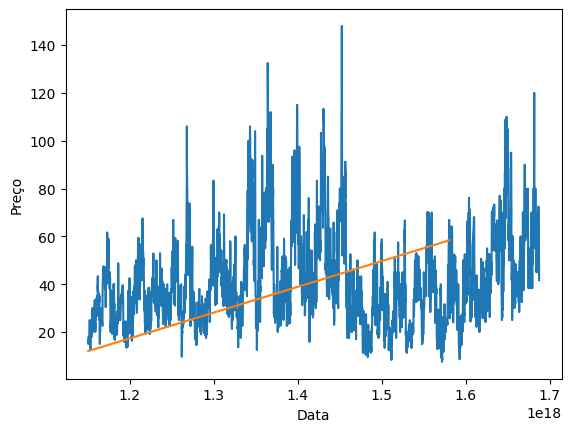

In [68]:
d = {'tempo': x_treino, 'preco': y_predict[:,0]}
resultados = pd.DataFrame(data=d)
resultado_transf = sc.inverse_transform(resultados)
resultado_transf = pd.DataFrame(resultado_transf)
resultado_transf.columns = ['Data','Preço']
sns.lineplot(x="Data",y="Preço",data=df_preco_sp_italiano)
sns.lineplot(x="Data",y="Preço",data=resultado_transf)

26/26 [==============================] - 0s 3ms/step
                     Data  Preço
4098  1685664000000000000  57.50
4099  1685923200000000000  50.00
4100  1686009600000000000  45.00
4101  1686096000000000000  50.00
4102  1686268800000000000  60.00
4103  1686528000000000000  68.33
4104  1686614400000000000  72.50
4105  1686700800000000000  72.50
4106  1686787200000000000  70.00
4107  1686873600000000000  65.00
4108  1687132800000000000  57.50
4109  1687219200000000000  48.33
4110  1687305600000000000  55.00
4111  1687392000000000000  50.00
4112  1687478400000000000  41.67
             Data      Preço
808  1.685664e+18  69.666700
809  1.685923e+18  69.694636
810  1.686010e+18  69.703948
811  1.686096e+18  69.713260
812  1.686269e+18  69.731882
813  1.686528e+18  69.759818
814  1.686614e+18  69.769130
815  1.686701e+18  69.778440
816  1.686787e+18  69.787752
817  1.686874e+18  69.797064
818  1.687133e+18  69.824998
819  1.687219e+18  69.834312
820  1.687306e+18  69.843622
821  1.687392

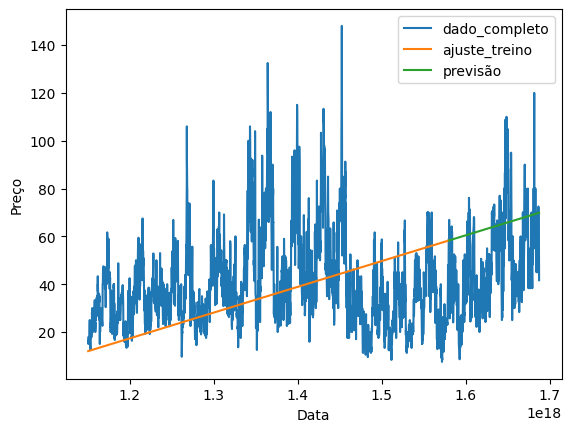

In [76]:
y_predict_teste= regressor.predict(x_teste)
d = {'Data': x_teste, 'Preço': y_predict_teste[:,0]}
resultados_teste = pd.DataFrame(data=d)
resultado_transf_teste = sc.inverse_transform(resultados_teste)
resultado_transf_teste = pd.DataFrame(resultado_transf_teste)
resultado_transf_teste.columns = ['Data','Preço']
sns.lineplot(x="Data",y="Preço",data=df_preco_sp_italiano,label='dado_completo')
sns.lineplot(x="Data",y="Preço",data=resultado_transf,label='ajuste_treino')
sns.lineplot(x="Data",y="Preço",data=resultado_transf_teste,label='previsão')
print(df_preco_sp_italiano.tail(15))
print(resultado_transf_teste.tail(15))